In [17]:
import numpy as np
from numpy import array
import pandas as pd
from scipy.special import erf
from scipy.optimize import curve_fit

from matplotlib import pyplot as plt

import pymc3 as pm
import arviz as az

import theano.tensor as tt
from theano.tensor import _shared

from util import util

In [18]:
# We import the sample_submission.csv file as a way of determining
# the order of the rows in out output file
sample_submission = pd.read_csv("../sample_submission.csv")

# The fips_key.csv file contains standard information about each county
key = pd.read_csv("../data/us/processing_data/fips_key.csv", encoding='latin-1')

# Daily deaths contains the death count per day for each county.
# Cumulative deaths contains the total death count for each county
# by day.
daily_deaths = pd.read_csv("../data/us/covid/nyt_us_counties_daily.csv")
cumulative_deaths = pd.read_csv("../data/us/covid/deaths.csv")
county_land_areas = pd.read_csv("../data/us/demographics/county_land_areas.csv", encoding='latin1')

# List of all counties
all_fips = key["FIPS"].tolist()

# Relevent dates
today = cumulative_deaths.columns[-1]
yesterday = cumulative_deaths.columns[-2]
one_week_ago = cumulative_deaths.columns[-8]
two_weeks_ago = cumulative_deaths.columns[-15]
beginning = cumulative_deaths.columns[4]

In [19]:
# Assume date is in format mm/dd/yy, convert to yyyy-mm-dd
def convert_date_to_yyyy_mm_dd(date):
    parts = date.split('/')
    
    # Ensure leading zeros if necessary
    if len(parts[0]) == 1:
        parts[0] = "0" + parts[0]
    
    if len(parts[1]) == 1:
        parts[1] = "0" + parts[1]
        
    return "2020" + "-" + parts[0] + "-" + parts[1]

# Assume date is in format yyyy-mm-dd, convert to mm/dd/yy
def convert_date_to_mm_dd_yy(date):
    parts = date.split('-')
    
    # Remove leading zeros if necessary
    if parts[1][0] == "0":
        parts[1] = parts[1][1:]
    
    if parts[2][0] == "0":
        parts[2] = parts[2][1:]
        
    return parts[1] + "/" + parts[2] + "/" + "20"

In [20]:
util = util(daily_deaths, cumulative_deaths, county_land_areas, key)

In [28]:
def func(x, a, b, c, d):
    return a * erf(b * (x - c)) + d

def linear(x, a, b):
    return x * a + b

In [29]:
def get_erf_coefs(x, y):
    popt, pcov = curve_fit(func, x, y)
    return popt

def get_linear_coefs(x, y):
    popt, pcov = curve_fit(linear, x, y)
    return popt

In [33]:
# Custom mean function
class Erf(pm.gp.mean.Mean):
    def __init__(self, a, b, c, d):
        pm.gp.mean.Mean.__init__(self)
        self.a = a
        self.b = b
        self.c = c
        self.d = d

    def __call__(self, X):
        print(tt.alloc(1.0, X.shape[0]) * self.c)
        means = []
        for x in X:
            means.append(self.a * erf(self.b * (x - self.c)) + self.d)
        
        return _shared(array(means))

In [35]:
fips = 6037

daily_deaths_list = util.get_deaths_list(fips, endDate=convert_date_to_yyyy_mm_dd(two_weeks_ago))
cumulative_deaths_list = []

curr = 0
for i in range(len(daily_deaths_list) - 1):
    curr += daily_deaths_list[i]
    cumulative_deaths_list.append(curr)

x = array([i for i in range(len(cumulative_deaths_list))])

erf_coefs = get_erf_coefs(x, cumulative_deaths_list)
linear_coefs = get_linear_coefs(x, cumulative_deaths_list)

with pm.Model() as gp_covid_model:
    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 10)
    η = pm.HalfCauchy('η', 10)

    M = pm.gp.mean.Linear(coeffs=linear_coefs[0], intercept=linear_coefs[1])
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 

    σ = pm.HalfNormal('σ', 50)
    gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    gp.marginal_likelihood('dates', X=x.reshape(-1, 1),  y=cumulative_deaths_list, noise=σ)

with gp_covid_model:
    gp_trace = pm.sample(1000, tune=2000, cores=10, random_seed=42)

/usr/local/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/usr/local/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

In [36]:
X_pred = np.linspace(0, len(cumulative_deaths_list) + 20, 100)
with gp_covid_model:
    covid_pred = gp.conditional("deaths_pred", X_pred.reshape(-1, 1))
    gp_samples = pm.sample_posterior_predictive(gp_trace, vars=[covid_pred], samples=3, random_seed=42)

/usr/local/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/usr/local/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result 

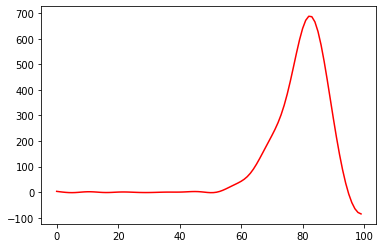

In [58]:
util.plot_list(gp_samples["deaths_pred"][0])

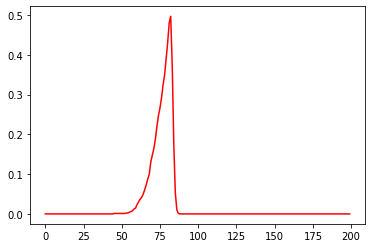

In [240]:
x = [[i] for i in range(200)]
y_pred, std = gp.predict(x, return_std=True)
util.plot_list(y_pred)